<a href="https://colab.research.google.com/github/jenelaineDC/DSML-PROJECTS/blob/main/Waze%20Customer%20Churn/Waze_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BACKGROUND

The Waze data team is developing a data analytics project to address the challenge of monthly user churn. For this project, churn is defined as users who either uninstall the app or stop using it entirely. Churn represents a significant barrier to growth, as acquiring new users is more costly than retaining existing ones.

By predicting churn, Waze can take proactive measures to retain users, such as improving in-app experiences, personalizing engagement, and targeting at-risk users with retention campaigns. Reducing churn will not only lower acquisition costs but also strengthen long-term user loyalty, increase app engagement, and support sustainable growth for Waze’s platform.

### PROJECT GOAL

The primary goal of this project is to analyze user data to uncover patterns and factors that influence churn. Specifically, the aim is to:
- Build machine learning models that estimate whether a user is likely to churn.
- Compare the performance of different algorithms (e.g., Random Forest, XGBoost) to identify the most effective approach.
- Provide actionable insights to support product and engagement strategies that improve user retention.

### SCOPE AND LIMITATION

This project will:
- Use the current user dataset collected by Waze.
- Explore the impact of engineered features on model performance.

This project will not:
- Collect new data beyond what is already available at this stage.
- Address external factors such as competitor activity or broader market trends.
- Deploy the models into production but will instead inform future iterations of the project.

#### SET-UP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DSML PROJECTS/Waze Customer Churn

/content/drive/MyDrive/DSML PROJECTS/Waze Customer Churn


In [104]:
# for operational libraries
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# for train test val split
from sklearn.model_selection import train_test_split, PredefinedSplit

# evaluation metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# import available models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# # This module lets us save our models once we fit them.
import pickle
import joblib

### DATA DEVELOPMENT PROCESS

##### Data Source
This dataset is supplied as part of the Google Advanced Data Analytics Professional Certificate program courses on Coursera. According to Google, this dataset contains synthetic data created in partnership with Waze. It contains 14, 999 entries and 13 attributes listed below.

[Google Advance Data Analytics Course 6 Project](https://www.coursera.org/professional-certificates/google-advanced-data-analytics?action=enroll&msockid=2cdd450308916b111b1251dc09516a30)

| Variable | Description |
|---------|-------------|
| ID | Unique identifier for each user |
| label | Binary target variable indicating user status: `retained` or `churned` |
| sessions | Number of times the user opened the app during the month |
| drives | Number of driving sessions (≥1 km) during the month |
| total_sessions | Estimated total number of sessions since user onboarding |
| n_days_after_onboarding | Number of days since the user signed up for the app |
| total_navigations_fav1 | Total navigations to favorite place 1 since onboarding |
| total_navigations_fav2 | Total navigations to favorite place 2 since onboarding |
| driven_km_drives | Total kilometers driven during the month |
| duration_minutes_drives | Total driving duration in minutes during the month |


In [4]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [6]:
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [7]:
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [8]:
df0.columns

Index(['ID', 'label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

In [9]:
# Check for missing values
df0.isnull().sum()

,0
ID,0
label,700
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


##### Missing Values, Duplicates and Unnecessary Columns

In [10]:
df0 = df0.dropna()

In [11]:
df0.isnull().sum()

,0
ID,0
label,0
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [12]:
df0 = df0.drop(columns='ID')
df0.columns

Index(['label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

##### Outlier Detection

As part of the exploratory analysis, I examined the distributions of the numerical variables using histograms and boxplots. Overall, most of the features showed varying degrees of right skewness, with clear outliers that highlight differences in user behavior patterns.

- **`sessions`**: This variable, which captures how often a user opened the app in the last month, shows a right-skewed distribution. Half of the users had 56 or fewer sessions, while a small group of heavy users logged over 700 sessions, marking them as clear outliers.

- **`drives`**: Similar to `sessions`, the number of drives (≥1 km) is also right-skewed and approximately log-normal. The median is 48, but some drivers recorded 400+ drives in a single month, suggesting a subset of highly active or possibly professional users.

- **`total_sessions`**: The total number of sessions since onboarding is also skewed to the right, with a median of ~160 sessions. Compared to the monthly median of ~48 sessions, this indicates that a significant portion of a user’s total activity often occurs in just the most recent month, which is worth deeper analysis.

- **`n_days_after_onboarding`**: This variable, representing user tenure, is uniformly distributed across the range of 0 to ~3,500 days (~9.5 years). Unlike usage features, tenure does not show clustering or heavy skewness.

- **`driven_km_drives`**: The total kilometers driven in the last month shows strong right skew. Half of users drove under ~3,495 km, while the most extreme case exceeded 20,000 km, which is over half the circumference of the Earth. These extreme long-distance drivers clearly stand out as outliers.

- **`duration_minutes_drives`**: Total minutes driven also follows a heavy right-skew. The median is ~1,478 minutes (~25 hours), but some users drove 15,000+ minutes (>250 hours) in one month, again suggesting a small group of outlier users with unusually high activity.

- **`activity_days`**: The number of days a user opened the app in the last month has a median of 16 days and a nearly uniform distribution across the range. Interestingly, ~250 users did not open the app at all, while another ~250 opened it every single day. Unlike `sessions`, which is more skewed, this variable shows a flatter distribution and warrants comparison.

- **`driving_days`**: The number of days a user drove is also fairly uniform but drops off in the higher counts compared to `activity_days`. Notably, almost twice as many users (~1,000) did not drive at all compared to those who didn’t open the app (~550). This discrepancy between app activity and actual driving behavior should be flagged for deeper investigation.

From this outlier analysis, it is clear that several variables (e.g., `sessions`, `drives`, `driven_km_drives`, `duration_minutes_drives`) contain extreme values that could influence model training. The right-skewed distributions suggest that some users are highly active or professional drivers, while others are casual or inactive. These patterns will inform feature transformations, potential log-scaling, or outlier treatment to ensure the churn prediction model is robust and not unduly influenced by extreme user behavior. Additionally, discrepancies between `activity_days` and `driving_days` highlight behavioral segments that may be important predictors of churn.


In [13]:
num_col = ['sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days']
cat_col = ['label', 'device']

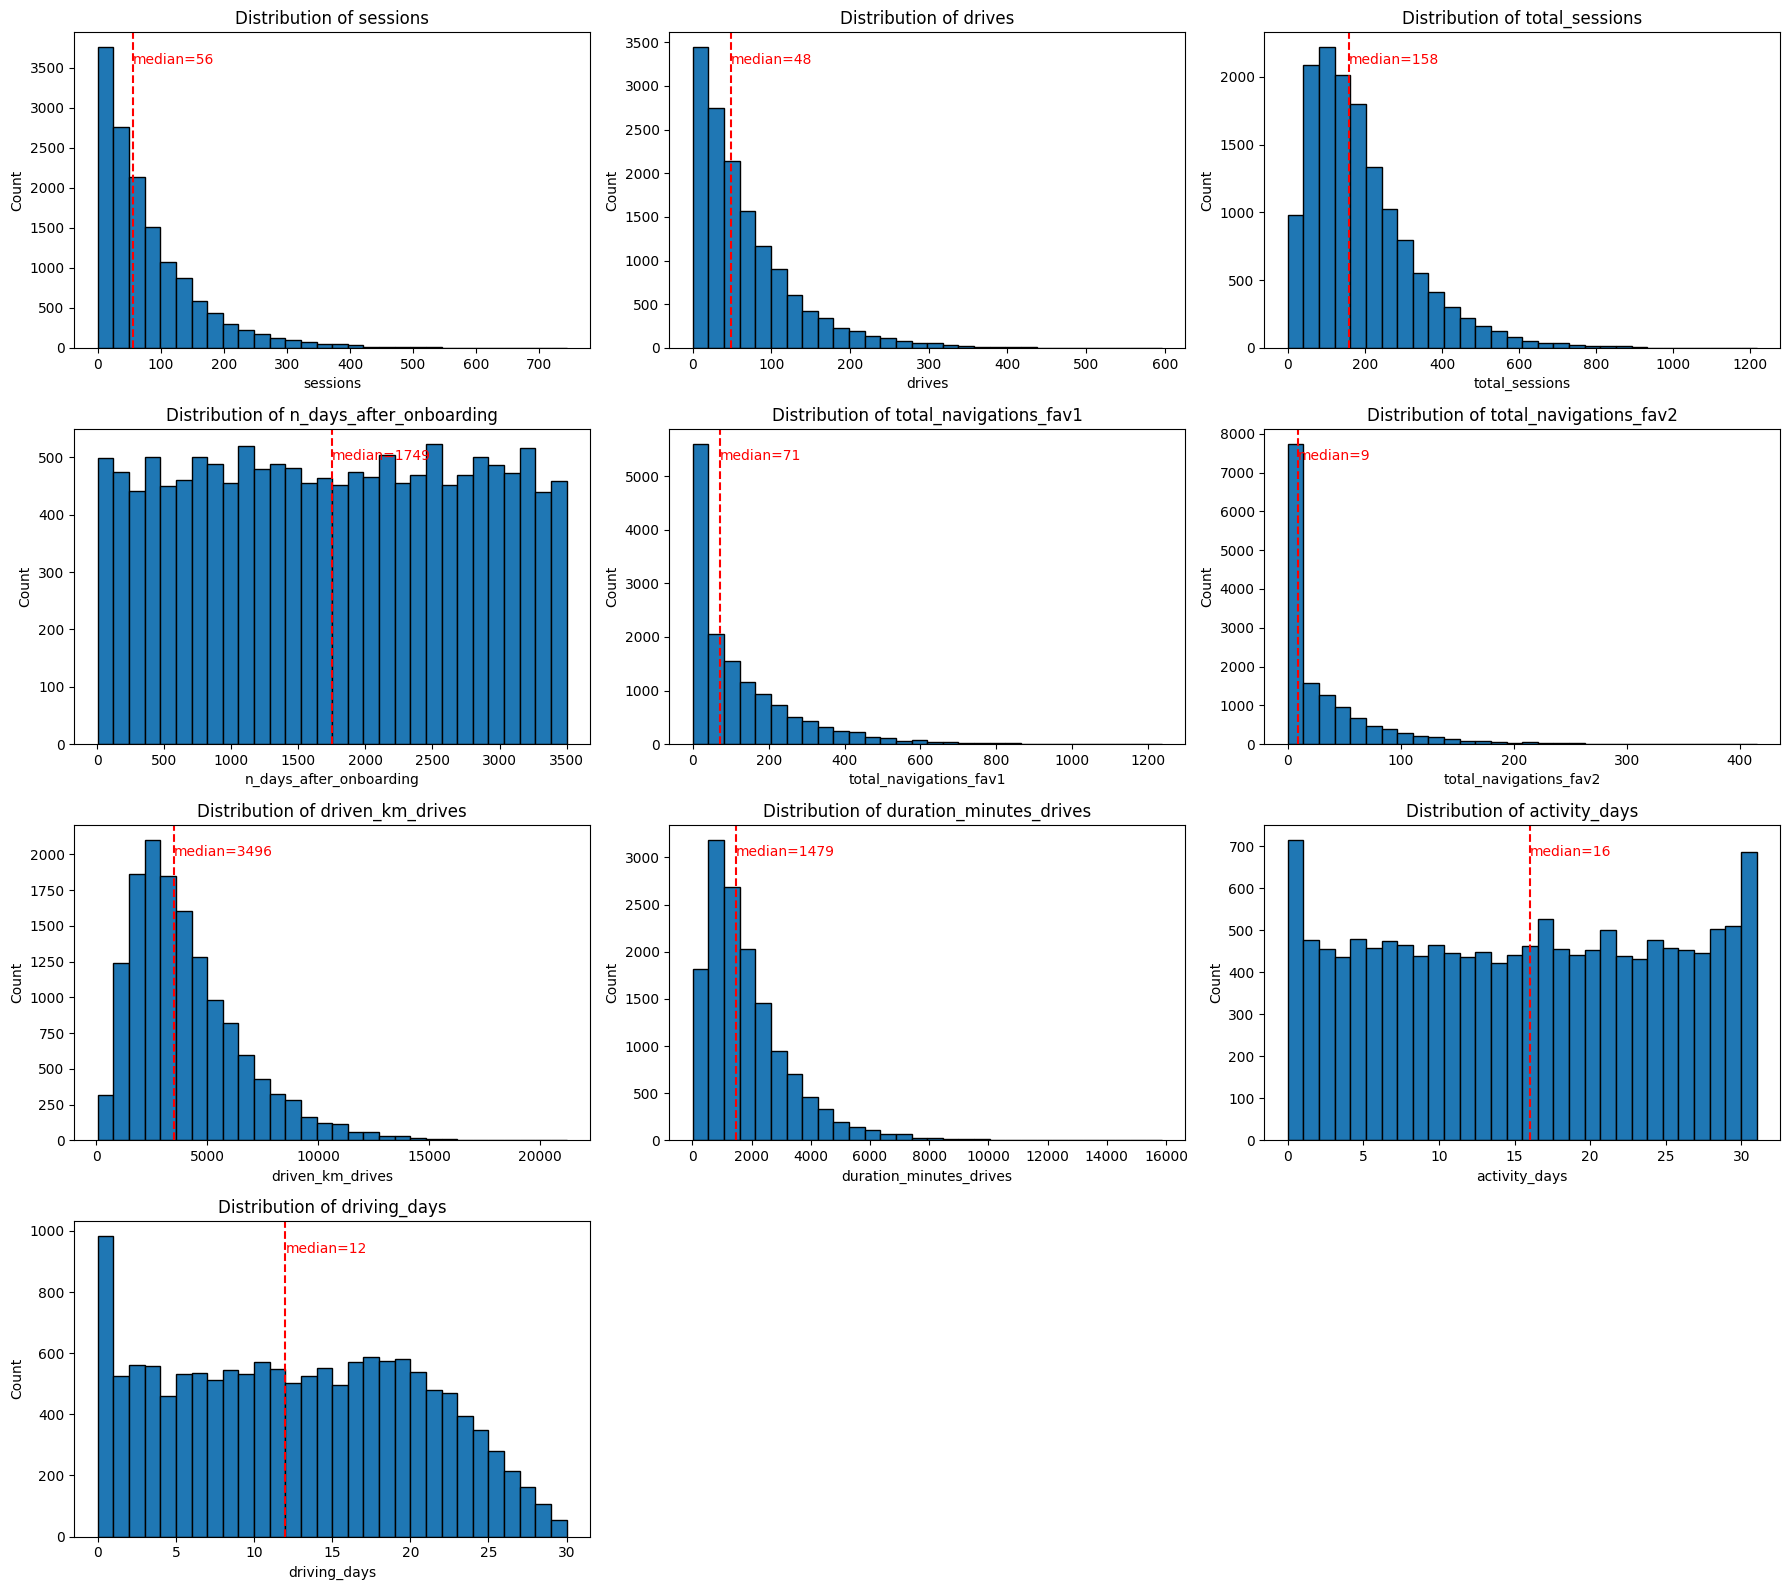

In [14]:
# Create subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(num_col):
    axes[i].hist(df0[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    # Median line
    median = df0[col].median()
    axes[i].axvline(median, color='red', linestyle='--')
    axes[i].text(median, axes[i].get_ylim()[1]*0.9, f'median={int(median)}', color='red')

# Remove empty subplots if num_col < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




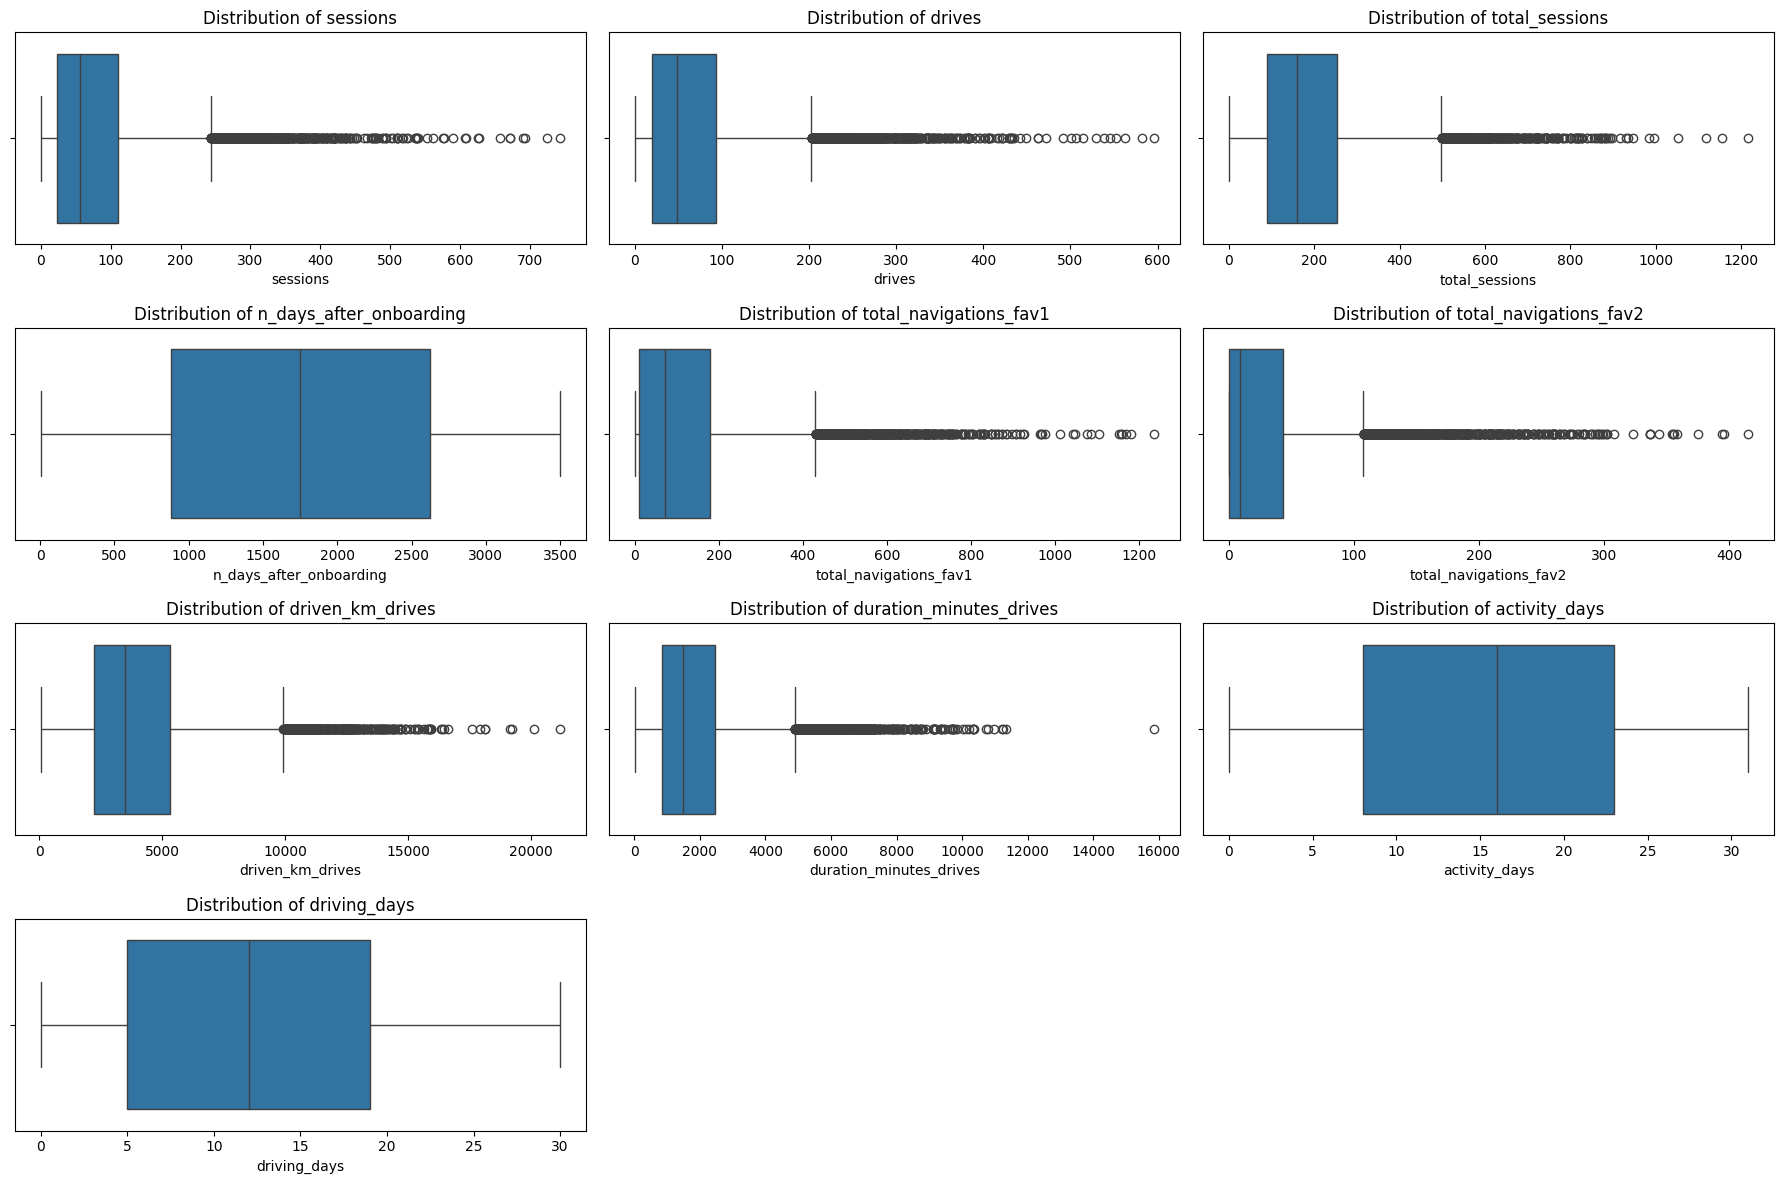

In [15]:
# Create subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
axes = axes.flatten()

sns.set(style="whitegrid")

for i, col in enumerate(num_col):
    sns.boxplot(x=df0[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Remove empty subplots if num_col < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##### Feature Engineering

To improve the model’s ability to detect churn, I engineered several new features. Each feature is designed not only to add predictive value but also to provide business-relevant insights into user behavior:

- **`km_per_driving_day`**: Represents the average kilometers driven on each active driving day in the last month, giving a normalized view of driving intensity and helping differentiate light users from heavy or more dependent drivers.  

- **`percent_sessions_in_last_month`**: Measures the share of a user’s total sessions that occurred in their last active month, capturing recency of engagement.  

- **`professional_driver`**: A binary flag identifying users with at least 60 drives and 15 active driving days in the last month, allowing the model to distinguish highly active or professional drivers from casual ones.  

- **`total_sessions_per_day`**: The average number of sessions per day since onboarding, reflecting overall long-term engagement relative to account age.  

- **`km_per_hour`**: The average kilometers driven per hour in the last month.

- **`km_per_drive`**: The average distance per trip in the last month, highlighting driving habits at the trip level and differentiating short, casual usage from longer, more dependent use cases.  

- **`percent_of_sessions_to_favorite`**: The percentage of sessions used to navigate to saved favorite places, serving as a proxy for loyalty and habitual app usage.  

In [16]:
# Copy the df0 dataframe
df = df0.copy()

**`km_per_driving_day`**

In [17]:
#  Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# Get descriptive stats
df['km_per_driving_day'].describe()

,km_per_driving_day
count,1.429900e+04
mean,inf
std,NaN
min,3.022063e+00
25%,1.675616e+02
50%,3.241789e+02
75%,7.608293e+02
max,inf


In [18]:
# Convert infinite values to zero.
# These infinite values were a result of 0 values in driving_days column.
df['km_per_driving_day'] = df['km_per_driving_day'].replace([np.inf, -np.inf], 0)

# Confirm that it worked
df['km_per_driving_day'].describe()

,km_per_driving_day
count,14299.000000
mean,581.942399
std,1038.254509
min,0.000000
25%,136.168003
50%,273.301012
75%,558.018761
max,15420.234110


In [19]:
np.isinf(df['km_per_driving_day']).sum() #count the inf values

np.int64(0)

**`percent_session_in_last_month`**

In [20]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions']/df['total_sessions']

# Get descriptive stats
df['percent_sessions_in_last_month'].describe()

,percent_sessions_in_last_month
count,14299.000000
mean,0.449837
std,0.286863
min,0.000000
25%,0.196890
50%,0.424310
75%,0.687251
max,1.530637


**`professional_driver`**

In [21]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0).astype(int)
df['professional_driver'].unique()

array([1, 0])

**`total_sessions_per_day`**

In [22]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']

# Get descriptive stats
df['total_sessions_per_day'].describe()

,total_sessions_per_day
count,14299.000000
mean,0.338207
std,1.319814
min,0.000298
25%,0.050818
50%,0.100457
75%,0.215210
max,39.763874


**`km_per_hour`**

In [23]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives']/(df['duration_minutes_drives']/60)
df['km_per_hour'].describe()

,km_per_hour
count,14299.000000
mean,190.730963
std,339.926138
min,72.013095
25%,90.649402
50%,122.105845
75%,193.238449
max,23642.920871


**`km_per_drive`**

In [24]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives']/df['drives']
df['km_per_drive'].describe()

,km_per_drive
count,1.429900e+04
mean,inf
std,NaN
min,1.008775e+00
25%,3.325389e+01
50%,7.490594e+01
75%,1.854667e+02
max,inf


In [25]:
# Convert infinite values to zero
df['km_per_drive'] = df['km_per_drive'].replace([np.inf, -np.inf], 0)
# Confirm that it worked
df['km_per_drive'].describe()

,km_per_drive
count,14299.000000
mean,232.269197
std,616.197409
min,0.000000
25%,32.486524
50%,72.947059
75%,179.347527
max,15777.426560


In [26]:
np.isinf(df['km_per_drive']).sum() #count the inf values

np.int64(0)

**`percent_of_sessions_to_favorite`**

In [27]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] +
                                         df['total_navigations_fav2']) /df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

,percent_of_sessions_to_favorite
count,14299.000000
mean,1.676347
std,9.021250
min,0.000000
25%,0.206064
50%,0.653572
75%,1.643183
max,777.563629


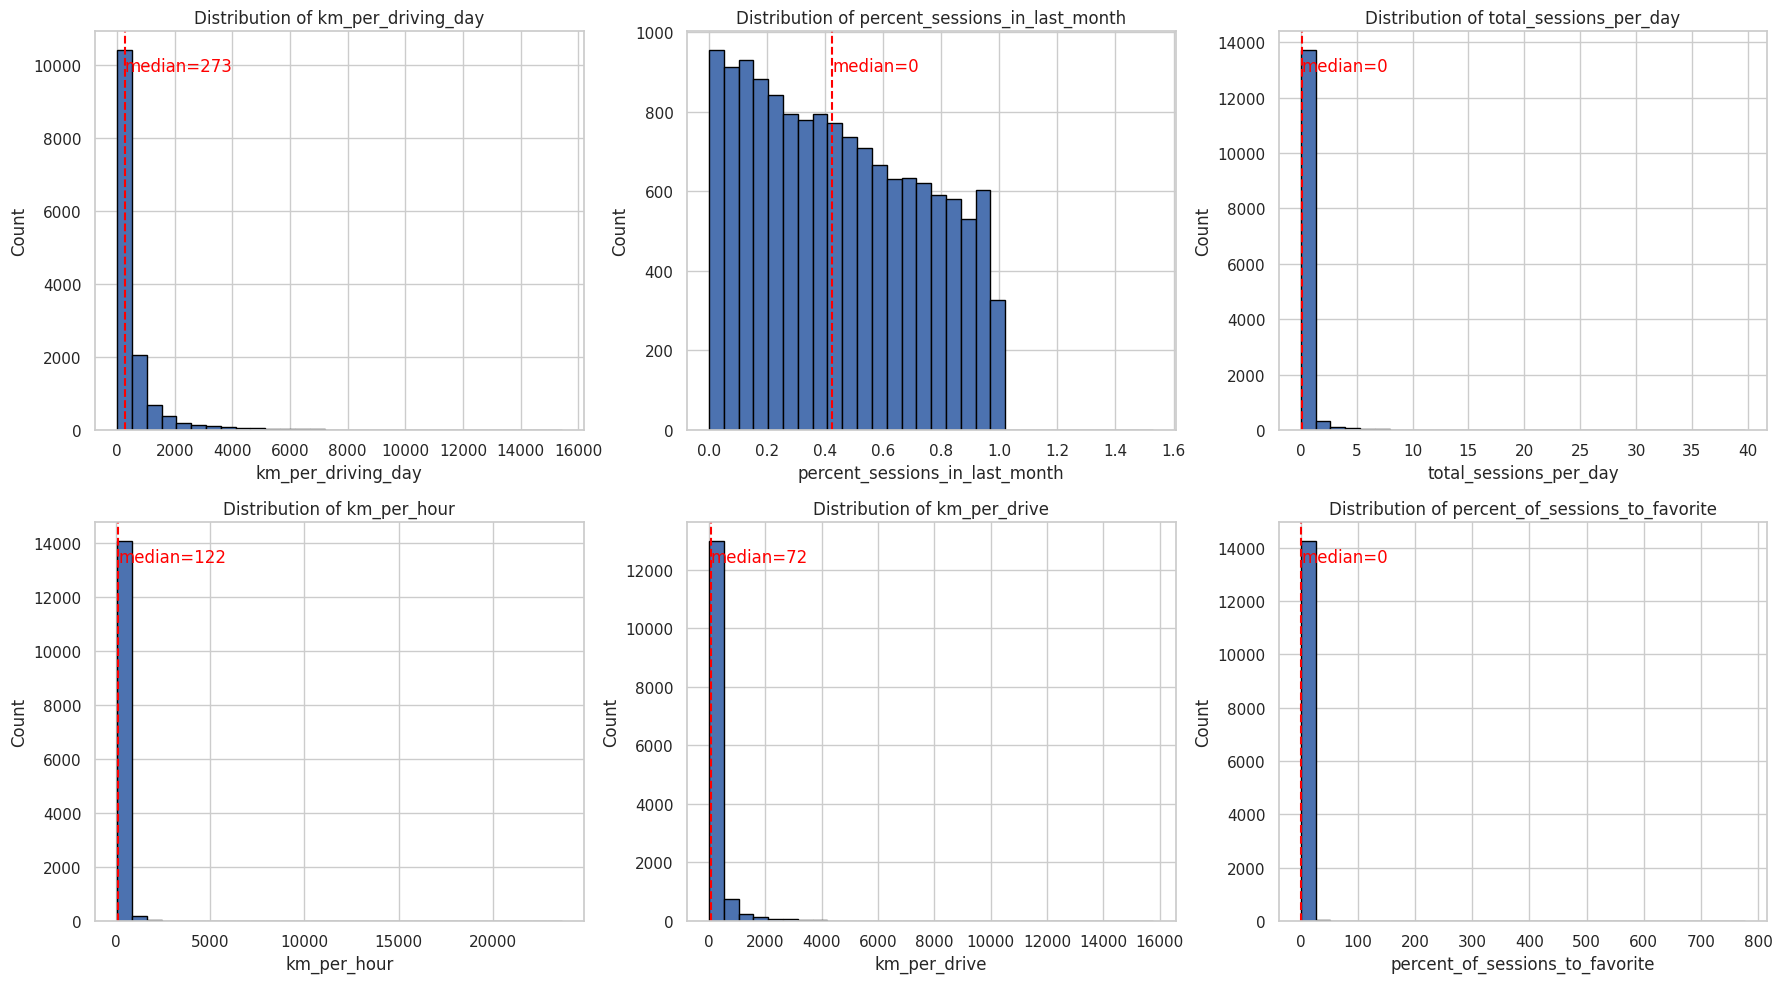

In [28]:
num_col = ['km_per_driving_day',
       'percent_sessions_in_last_month',
       'total_sessions_per_day', 'km_per_hour', 'km_per_drive',
       'percent_of_sessions_to_favorite']

# Create subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_col):
    axes[i].hist(df[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    # Median line
    median = df[col].median()
    axes[i].axvline(median, color='red', linestyle='--')
    axes[i].text(median, axes[i].get_ylim()[1]*0.9, f'median={int(median)}', color='red')

# Remove empty subplots if num_col < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


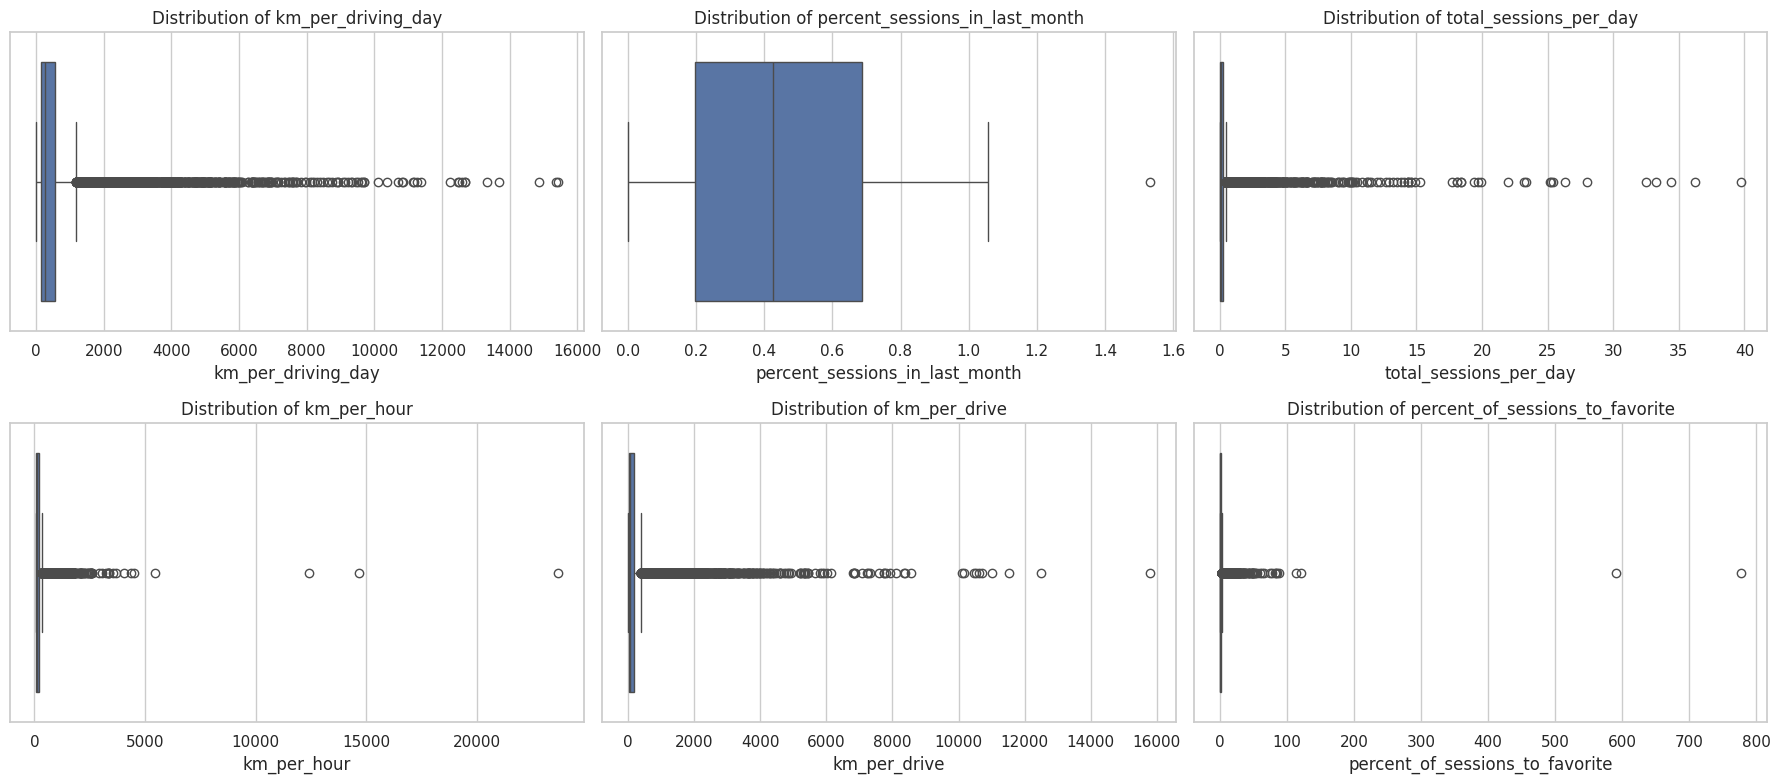

In [29]:
# Create subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

sns.set(style="whitegrid")

for i, col in enumerate(num_col):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Remove empty subplots if num_col < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

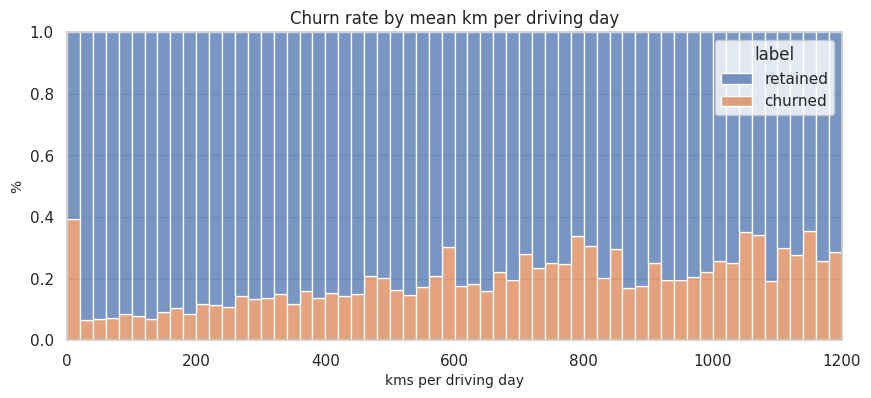

In [113]:
# Histogram
# Create a bar plot
plt.figure(figsize=(10, 4))  # Adjust the size of the plot
sns.histplot(x='km_per_driving_day', hue='label', data=df, multiple = 'fill', bins = range(0, 1201, 20))

# Set the title and axis labels
plt.title('Churn rate by mean km per driving day', fontsize=12)
plt.xlabel('kms per driving day', fontsize=10)
plt.ylabel('%', fontsize=10)

# Show the plot
plt.show()

The churn rate tends to increase as the mean daily distance driven increases. It would be worth investigating further the reasons for long-distance users to discontinue using the app.

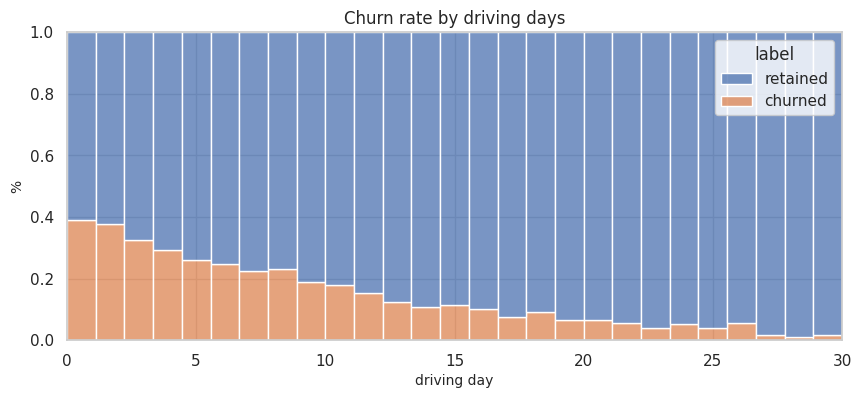

In [114]:
# Histogram
# Create a bar plot
plt.figure(figsize=(10, 4))  # Adjust the size of the plot
sns.histplot(x='driving_days', hue='label', data=df, multiple = 'fill')

# Set the title and axis labels
plt.title('Churn rate by driving days', fontsize=12)
plt.xlabel('driving day', fontsize=10)
plt.ylabel('%', fontsize=10)

# Show the plot
plt.show()

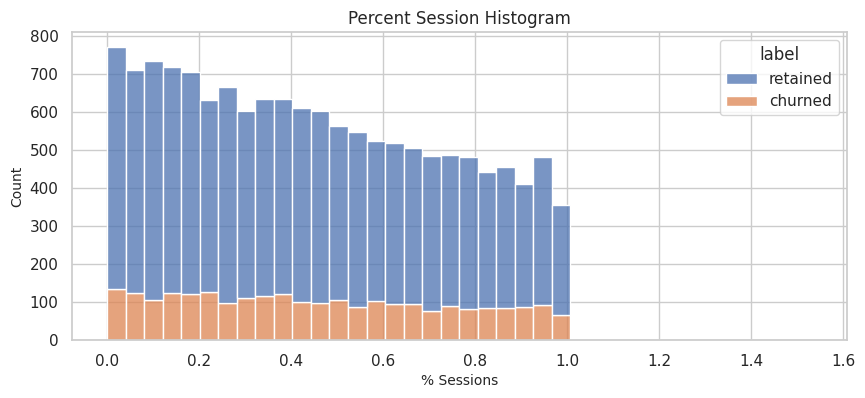

In [116]:
# Histogram
# Create a bar plot
plt.figure(figsize=(10, 4))  # Adjust the size of the plot
sns.histplot(x='percent_sessions_in_last_month', hue='label', data=df, multiple = 'stack')

# Set the title and axis labels
plt.title('Percent Session Histogram', fontsize=12)
plt.xlabel('% Sessions', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Show the plot
plt.show()

##### Variable Encoding

- `device2`: Create a new, binary column called device2 that encodes user devices as follows:
  - Android -> 0
  - iPhone  -> 1

- `label2 `: The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the label column to be binary.
  - retained -> 0
  - churned -> 1

**`device2`**

In [30]:
# Create new `device2` variable
df['device2'] = np.where((df['device'] == "Android"), 0,1)
df[['device', 'device2']].head(5)

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


**`label2`**

In [31]:
# Create binary `label2` column
df['label2'] = np.where((df['label'] == "retained"), 0,1)
df[['label', 'label2']].tail(5)

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


##### Outlier Handling

From the previous section, the boxplots indicated that many of these numerical variables contain clear outliers. Based on my analysis, these outliers do not appear to be data entry errors—they arise naturally from the right-skewed distributions of the variables.

Depending on how the data will be used, it may be useful to handle these extreme values to reduce their impact on modeling. One approach is to **impute outlying values with more reasonable thresholds**, rather than removing them entirely. A common technique is to set a threshold based on a specific percentile of the distribution.

A function that calculates the **95th percentile** for a given column and then replaces any value exceeding this percentile with the 95th percentile value itself will be used. This ensures that extreme values are capped while preserving the overall distribution structure.

However, for a tree based model, it is not necessary to impute this outliers. So a different dataframe will be used for Logistic Regression model and Tree-based model.


In [32]:
def cap_outliers(df_input, columnname, percentile=0.95):
    """
    Caps values above a given percentile for a specified column in a DataFrame.

    Parameters:
    df_input (pd.DataFrame): The DataFrame to modify
    columnname (str): The column to cap
    percentile (float): The percentile threshold (default is 0.95)

    Returns:
    pd.DataFrame: DataFrame with capped column
    """
    p_val = round(df_input[columnname].quantile(percentile), 2)
    df_input[columnname] = df_input[columnname].where(df_input[columnname] < p_val, p_val)
    print(f"{columnname} capped at {int(percentile*100)}th percentile: {p_val}")
    return df_input

In this section we will create a separate dataframe `df_clean` where in we pass the function `cap_outliers` we have created earlier for outlier handling.

This `df_clean` will be used to model our logistic regression while `df` will be retained as is without outlier handling will be used for our tree-based model.

In [33]:
df_clean = df.copy()

In [34]:
column_list = ['sessions', 'drives', 'total_sessions', 'driven_km_drives', 'duration_minutes_drives',
               'total_navigations_fav1', 'total_navigations_fav2',
               'km_per_driving_day', 'percent_sessions_in_last_month', 'total_sessions_per_day', 'km_per_hour',
               'km_per_drive', 'percent_of_sessions_to_favorite']

for columnname in column_list:
    df_clean = cap_outliers(df_clean, columnname)

sessions capped at 95th percentile: 243.0
drives capped at 95th percentile: 200.0
total_sessions capped at 95th percentile: 455.44
driven_km_drives capped at 95th percentile: 8898.72
duration_minutes_drives capped at 95th percentile: 4668.18
total_navigations_fav1 capped at 95th percentile: 422.0
total_navigations_fav2 capped at 95th percentile: 124.0
km_per_driving_day capped at 95th percentile: 2258.49
percent_sessions_in_last_month capped at 95th percentile: 0.94
total_sessions_per_day capped at 95th percentile: 1.09
km_per_hour capped at 95th percentile: 488.82
km_per_drive capped at 95th percentile: 913.88
percent_of_sessions_to_favorite capped at 95th percentile: 5.5


In [35]:
df_clean.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717329,1751.822505,114.562767,27.187216,3944.558817,1792.911206,15.544653,12.182530,484.488320,0.448404,0.173998,0.203313,165.698526,168.147230,1.230230,0.645150,0.177355
std,67.243178,55.127927,118.720578,1008.663834,124.378550,36.715302,2218.358674,1224.329748,9.016088,7.833835,570.871631,0.284261,0.379121,0.267779,110.185034,232.904094,1.474272,0.478485,0.381982
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298,72.013095,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.196890,0.000000,0.050818,90.649402,32.486524,0.206064,0.000000,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.424310,0.000000,0.100457,122.105845,72.947059,0.653572,1.000000,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.687251,0.000000,0.215210,193.238449,179.347527,1.643183,1.000000,0.000000
max,243.000000,200.000000,455.440000,3500.000000,422.000000,124.000000,8898.720000,4668.180000,31.000000,30.000000,2258.490000,0.940000,1.000000,1.090000,488.820000,913.880000,5.500000,1.000000,1.000000


In [36]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530,581.942399,0.449837,0.173998,0.338207,190.730963,232.269197,1.676347,0.645150,0.177355
std,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835,1038.254509,0.286863,0.379121,1.319814,339.926138,616.197409,9.021250,0.478485,0.381982
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298,72.013095,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.196890,0.000000,0.050818,90.649402,32.486524,0.206064,0.000000,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.424310,0.000000,0.100457,122.105845,72.947059,0.653572,1.000000,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.687251,0.000000,0.215210,193.238449,179.347527,1.643183,1.000000,0.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15420.234110,1.530637,1.000000,39.763874,23642.920871,15777.426560,777.563629,1.000000,1.000000


### Evaluation Metric Selection

Before moving into the modeling phase, it was important to establish how the model’s performance would be evaluated. This decision depends on both the distribution of the target variable and the business use case.

Our analysis of the dataset showed that approximately 18% of users have churned. While this indicates a degree of imbalance, it is not extreme, and we can proceed without applying rebalancing techniques.

When selecting an evaluation metric, accuracy is not ideal in this scenario. With an imbalanced dataset, accuracy can appear high while still failing to identify the users who are most at risk of churn—the group we are most interested in.

From a business perspective, the risk of a false positive prediction (predicting churn when a user does not churn) is low. Such predictions do not cause financial loss or other negative consequences. However, failing to identify true churners could result in missed opportunities to engage and retain valuable customers.

For this reason, recall was chosen as the key evaluation metric. By focusing on recall, we ensure that the model is optimized to correctly capture as many churned users as possible, aligning directly with our business goal of reducing customer attrition.

In [37]:
# Get class balance of 'label' col
df['label'].value_counts(normalize = True)

,proportion
label,
retained,0.822645
churned,0.177355


### MODEL DEVELOPMENT

The final modeling dataset contains **14,299 samples**. While this is at the lower end of what is generally recommended for a robust model selection process, it remains sufficient to derive meaningful insights and make data-driven decisions.

To ensure a rigorous modeling approach, I implemented the following workflow:

1. **Data Partitioning (Train/Validation/Test)**  
   I split the dataset into **60/20/20** proportions. When determining the split, I carefully considered both the total number of samples per partition and the representation of the **minority class (churned users)**.  
   - With this split, the **validation and test sets each contain ~2,860 samples**, including approximately **515 churn instances (18%)**, providing a reliable basis for evaluating model performance and minimizing sampling bias.

2. **Model Training and Hyperparameter Optimization**  
   All candidate models were trained on the **training set**, with hyperparameters tuned to maximize predictive performance while preventing overfitting.  

3. **Model Selection Using Validation Set**  
   The **validation set** was used to compare candidate models and identify the **champion model** that best balances performance and generalizability.  

4. **Performance Assessment on Test Set**  
   Finally, the **champion model** was evaluated on the **test set** to confirm its predictive power on unseen data, ensuring the solution is robust for business decision-making.

This structured approach ensures that the churn prediction model is both statistically sound and actionable, providing business stakeholders with confidence in the insights derived from the analysis.

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


##### Train, Validate, Test Split

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
# Isolate X variables
X = df.copy().drop(columns = ['device', 'label', 'label2'], axis = 1)

# Isolate y variable
y = df['label2']

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)


# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)  # balance minority class
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE: ", y_train_res.value_counts())

Before SMOTE: label2
0    7057
1    1522
Name: count, dtype: int64
After SMOTE:  label2
1    7057
0    7057
Name: count, dtype: int64


In [40]:
# Create a DataFrame to display the shapes of the datasets
data_shapes = {
    'Set': ['Train', 'Train with SMOTE','Validate', 'Test'],
    'X Shape': [X_train.shape, X_train_res.shape, X_val.shape, X_test.shape],
    'Y Shape': [y_train.shape, y_train_res.shape, y_val.shape, y_test.shape]
}

df_shapes = pd.DataFrame(data_shapes)

# Print the table
print(df_shapes)

                Set      X Shape   Y Shape
0             Train   (8579, 18)   (8579,)
1  Train with SMOTE  (14114, 18)  (14114,)
2          Validate   (2860, 18)   (2860,)
3              Test   (2860, 18)   (2860,)


In [41]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [42]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

#### Model Training without SMOTE

##### Random Forest

In [43]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

# 5. Fit the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [44]:
print("Best Recall Score:", rf_cv.best_score_)
print("Best Hyperparameters:", rf_cv.best_params_)

Best Recall Score: 0.12481018119068162
Best Hyperparameters: {'max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [45]:
results = make_results('RandomForest Train', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.12481,0.196474,0.819326


##### XGBoost

In [46]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
xgb_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a list of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, xgb_params, scoring = scoring, refit = 'recall', cv = 5)

# 5. Fit the model
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [47]:
print("Best Recall Score:", xgb_cv.best_score_)
print("Best Hyperparameters:", xgb_cv.best_params_)

Best Recall Score: 0.17412424503882656
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 300}


In [48]:
xgb_result = make_results('XGBoost Train', xgb_cv, 'recall')
results = pd.concat([results, xgb_result], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
0,XGBoost Train,0.441180,0.174124,0.249251,0.813965


##### Logistic Regression

In [49]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(labels=['label2', 'professional_driver'])
num_cols

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days',
       'km_per_driving_day', 'percent_sessions_in_last_month',
       'total_sessions_per_day', 'km_per_hour', 'km_per_drive',
       'percent_of_sessions_to_favorite', 'device2'],
      dtype='object')

In [50]:
cat_cols = ['professional_driver', 'device2']
cat_cols

['professional_driver', 'device2']

In [51]:
num_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent'))])

In [52]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)],
    remainder='drop',
    n_jobs=-1)

In [53]:
# Isolate X variables
X_lr = df_clean.copy().drop(columns = ['device', 'label', 'label2'], axis = 1)

# Isolate y variable
y_lr = df['label2']

# Split into train and test sets
X_tr_lr, X_test_lr, y_tr_lr, y_test_lr = train_test_split(X_lr, y_lr, stratify=y_lr,
                                              test_size=0.2, random_state=42)

# Split into train and validate sets
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_tr_lr, y_tr_lr, stratify=y_tr_lr,
                                                  test_size=0.25, random_state=42)


# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)  # balance minority class
X_train_lr_res, y_train_lr_res = smote.fit_resample(X_train_lr, y_train_lr)

print("Before SMOTE:", y_train_lr.value_counts())
print("After SMOTE: ", y_train_lr_res.value_counts())

Before SMOTE: label2
0    7057
1    1522
Name: count, dtype: int64
After SMOTE:  label2
1    7057
0    7057
Name: count, dtype: int64


In [54]:
LRpipeline = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('logisticregclassifier', LogisticRegression(random_state = 42))
])

cv_params = {
                'logisticregclassifier__penalty' : ['l1', 'l2'],
                'logisticregclassifier__C' : [0.01, 10, 100],
                'logisticregclassifier__solver' : ['saga'], #need to use saga as this supports all penalty types
                'logisticregclassifier__max_iter' : [1000]
            }



scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc' : 'roc_auc'
    }

logit_cv = GridSearchCV(LRpipeline, cv_params, scoring = scoring, refit = 'recall', n_jobs = -1, cv = 5)

logit_cv.fit(X_train_lr, y_train_lr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_dr...
                                       ('logisticregclassifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregclassifier__C': [0.01, 10, 100],
                         'logisticregclassifier__max_iter': [1000],
                         'logisticregclassifier__penalty': ['l1', 'l2'],
                         'logisticregclassifier__solver': ['saga']},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [55]:
print("Best Recall Score:", logit_cv.best_score_)
print("Best Hyperparameters:", logit_cv.best_params_)

Best Recall Score: 0.09262295081967213
Best Hyperparameters: {'logisticregclassifier__C': 10, 'logisticregclassifier__max_iter': 1000, 'logisticregclassifier__penalty': 'l1', 'logisticregclassifier__solver': 'saga'}


In [56]:
logit_result = make_results('LogisticReg Train', logit_cv, 'recall')
results = pd.concat([results, logit_result], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
0,XGBoost Train,0.441180,0.174124,0.249251,0.813965
0,LogisticReg Train,0.585142,0.092623,0.158913,0.826670


##### Validation

In [57]:
# Use random forest model to predict on validation data
rf_val = rf_cv.best_estimator_.predict(X_val)

# Get validation scores for RF model
rf_val_results = get_test_scores('RandomForest Validation', rf_val, y_val)

# Append to the results table
results = pd.concat([results, rf_val_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
0,XGBoost Train,0.441180,0.174124,0.249251,0.813965
0,LogisticReg Train,0.585142,0.092623,0.158913,0.826670
0,RandomForest Validation,0.445255,0.120316,0.189441,0.817483


In [58]:
# Use XGBoost model to predict on validation data
xgb_val = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_results = get_test_scores('XGBoost Validation', xgb_val, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
0,XGBoost Train,0.441180,0.174124,0.249251,0.813965
0,LogisticReg Train,0.585142,0.092623,0.158913,0.826670
0,RandomForest Validation,0.445255,0.120316,0.189441,0.817483
0,XGBoost Validation,0.395556,0.175542,0.243169,0.806294


In [59]:
# Use Logit model to predict on validation data
lr_val = xgb_cv.best_estimator_.predict(X_val_lr)

# Get validation scores for Logit model
lr_val_results = get_test_scores('LogisticReg Validation', lr_val, y_val_lr)

# Append to the results table
results = pd.concat([results, lr_val_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
0,XGBoost Train,0.441180,0.174124,0.249251,0.813965
0,LogisticReg Train,0.585142,0.092623,0.158913,0.826670
0,RandomForest Validation,0.445255,0.120316,0.189441,0.817483
0,XGBoost Validation,0.395556,0.175542,0.243169,0.806294
0,LogisticReg Validation,0.397260,0.171598,0.239669,0.806993


#### Model Training with SMOTE

##### Random Forest

In [60]:
rf_cv.fit(X_train_res, y_train_res) #fit the training model with SMOTE

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [61]:
print("Best Recall Score:", rf_cv.best_score_)
print("Best Hyperparameters:", rf_cv.best_params_)

Best Recall Score: 0.845008261675263
Best Hyperparameters: {'max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [85]:
results_smote = make_results('RandomForest Train', rf_cv, 'recall')
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748


##### XGBoost

In [63]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
xgb_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a list of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, xgb_params, scoring = scoring, refit = 'recall', cv = 5)

# 5. Fit the model
xgb_cv.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [64]:
print("Best Recall Score:", xgb_cv.best_score_)
print("Best Hyperparameters:", xgb_cv.best_params_)

Best Recall Score: 0.8848285325939653
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 300}


In [86]:
xgb_result_smote = make_results('XGBoost Train', xgb_cv, 'recall')
results_smote = pd.concat([results_smote, xgb_result_smote], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
0,XGBoost Train,0.841417,0.884829,0.857513,0.859929


##### Logistic Regression

In [66]:
logit_cv.fit(X_train_lr_res, y_train_lr_res)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_dr...
                                       ('logisticregclassifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregclassifier__C': [0.01, 10, 100],
                         'logisticregclassifier__max_iter': [1000],
                         'logisticregclassifier__penalty': ['l1', 'l2'],
                         'logisticregclassifier__solver': ['saga']},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [67]:
print("Best Recall Score:", logit_cv.best_score_)
print("Best Hyperparameters:", logit_cv.best_params_)

Best Recall Score: 0.7552875725531688
Best Hyperparameters: {'logisticregclassifier__C': 10, 'logisticregclassifier__max_iter': 1000, 'logisticregclassifier__penalty': 'l1', 'logisticregclassifier__solver': 'saga'}


In [87]:
logit_result_smote = make_results('LogisticReg Train', logit_cv, 'recall')
results_smote = pd.concat([results_smote, logit_result_smote], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
0,XGBoost Train,0.841417,0.884829,0.857513,0.859929
0,LogisticReg Train,0.692902,0.755288,0.722473,0.710430


##### Validation

In [88]:
# Use random forest model to predict on validation data
rf_val_smote = rf_cv.best_estimator_.predict(X_val)

# Get validation scores for RF model
rf_val_results_smote = get_test_scores('RandomForest Validation', rf_val_smote, y_val)

# Append to the results table
results_smote = pd.concat([results_smote, rf_val_results_smote], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
0,XGBoost Train,0.841417,0.884829,0.857513,0.859929
0,LogisticReg Train,0.692902,0.755288,0.722473,0.710430
0,RandomForest Validation,0.312966,0.414201,0.356537,0.734965


In [89]:
# Use XGBoost model to predict on validation data
xgb_val_smote = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_results_smote = get_test_scores('XGBoost Validation', xgb_val_smote, y_val)

# Append to the results table
results_smote = pd.concat([results_smote, xgb_val_results_smote], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
0,XGBoost Train,0.841417,0.884829,0.857513,0.859929
0,LogisticReg Train,0.692902,0.755288,0.722473,0.710430
0,RandomForest Validation,0.312966,0.414201,0.356537,0.734965
0,XGBoost Validation,0.327619,0.339250,0.333333,0.759441


In [90]:
# Use Logit model to predict on validation data
lr_val_smote = xgb_cv.best_estimator_.predict(X_val_lr)

# Get validation scores for Logit model
lr_val_results_smote = get_test_scores('LogisticReg Validation', lr_val_smote, y_val_lr)

# Append to the results table
results_smote = pd.concat([results_smote, lr_val_results_smote], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
0,XGBoost Train,0.841417,0.884829,0.857513,0.859929
0,LogisticReg Train,0.692902,0.755288,0.722473,0.710430
0,RandomForest Validation,0.312966,0.414201,0.356537,0.734965
0,XGBoost Validation,0.327619,0.339250,0.333333,0.759441
0,LogisticReg Validation,0.329545,0.343195,0.336232,0.759790


In [99]:
# Remove index
results = results.reset_index(drop=True)
results_smote = results_smote.reset_index(drop=True)

#### Model Selection and Evaluation

For this project, I applied three different models to the dataset: Random Forest, XGBoost, and Logistic Regression. I split the data into training, validation, and test sets using a 60/20/20 ratio prior to model fitting. To evaluate model performance, I considered several metrics, including precision, recall, F1-score, and accuracy. Given the class imbalance in the dataset, I focused primarily on recall, since identifying churned users is the key business objective.

In the initial validation, all three models showed low recall scores, ranging from 0.12 to 0.17, indicating that the models were struggling to identify churned users effectively. To address this, I retrained the models using SMOTE to balance the training data.

After applying SMOTE, the models’ recall scores on the validation set improved significantly, ranging from 0.33 to 0.41. Based on these results, I selected the Random Forest model as the champion, which achieved a recall score of 0.41 on the validation set.

Finally, I evaluated the champion Random Forest model on the unseen test set, achieving a recall of 0.44, which demonstrates that the model generalizes well and effectively identifies users likely to churn. While precision is 0.30, meaning some retained users are misclassified as churners, the business impact is minimal because engaging these users is low-cost. The F1-score of 0.36 reflects a reasonable balance between recall and precision, and overall accuracy of 0.72 is less meaningful due to class imbalance.

From a business perspective, this model enables Waze to proactively target nearly half of at-risk users, allowing retention campaigns to focus resources effectively. Even capturing a portion of churners early could translate into hundreds of retained customers per month, enhancing overall customer lifetime value. With continued data collection and model iteration, there is potential to further improve recall and precision, maximizing ROI from retention efforts.

In [100]:
from IPython.display import display, HTML

# Concatenate HTML representations of the two dataframes
display(HTML(
    results.style.set_table_attributes("style='display:inline'")._repr_html_() +
    "&nbsp;&nbsp;&nbsp;&nbsp;" +  # some spacing between tables
    results_smote.style.set_table_attributes("style='display:inline'")._repr_html_()
))

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.467084,0.124810,0.196474,0.819326
1,XGBoost Train,0.441180,0.174124,0.249251,0.813965
2,LogisticReg Train,0.585142,0.092623,0.158913,0.826670
3,RandomForest Validation,0.445255,0.120316,0.189441,0.817483
4,XGBoost Validation,0.395556,0.175542,0.243169,0.806294
5,LogisticReg Validation,0.397260,0.171598,0.239669,0.806993
,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
1,XGBoost Train,0.841417,0.884829,0.857513,0.859929
2,LogisticReg Train,0.692902,0.755288,0.722473,0.710430


##### Testing

In [103]:
# Use random forest model to predict on validation data
rf_test = rf_cv.best_estimator_.predict(X_test)

# Get validation scores for RF model
rf_test_results = get_test_scores('RandomForest Test', rf_test, y_test)

# Append to the results table
results_smote = pd.concat([results_smote, rf_test_results], axis = 0)
results_smote

,model,precision,recall,F1,accuracy
0,RandomForest Train,0.804107,0.845008,0.819487,0.820748
1,XGBoost Train,0.841417,0.884829,0.857513,0.859929
2,LogisticReg Train,0.692902,0.755288,0.722473,0.710430
3,RandomForest Validation,0.312966,0.414201,0.356537,0.734965
4,XGBoost Validation,0.327619,0.339250,0.333333,0.759441
5,LogisticReg Validation,0.329545,0.343195,0.336232,0.759790
0,RandomForest Test,0.304828,0.435897,0.358766,0.723776


##### Confusion Matrix

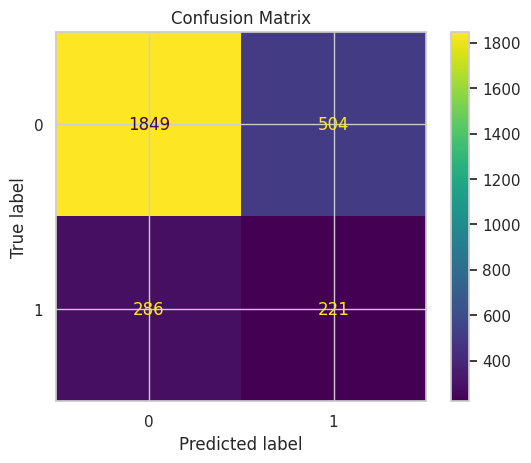

In [105]:
# Compute confusion matrix
cm = confusion_matrix(y_test, rf_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cv.best_estimator_.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

##### Feature Importance

Based on the feature importance analysis, the champion Random Forest model relies most heavily on activity_days, followed by n_days_after_onboarding and total_navigations_fav2 when making predictions.

Notably, several of our engineered features—including km_per_hour, km_per_drive, total_sessions_per_day, and percent_sessions_in_last_month—rank among the top 10 most influential features. This highlights the tangible impact of feature engineering in improving model performance and demonstrates how carefully crafted variables can capture critical behavioral patterns that standard features may miss.

It is worth noting, however, that feature importance rankings can vary across tree-based models such as Random Forest and XGBoost. While Random Forest highlights certain variables as most influential, another model might weigh features differently. This reinforces the importance of comparing multiple models to validate which signals consistently drive churn prediction.

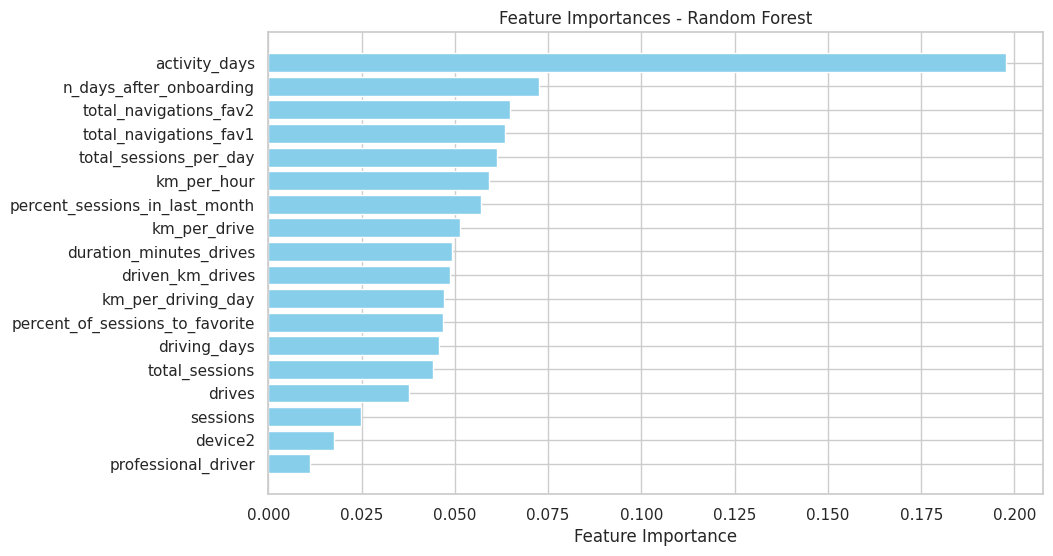

In [108]:
# Get the best trained Random Forest from GridSearchCV
best_rf = rf_cv.best_estimator_

# Extract feature importances
importances = best_rf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['feature'][:][::-1],
    feature_importance_df['importance'][:][::-1],
    color='skyblue'
)
plt.xlabel("Feature Importance")
plt.title("Feature Importances - Random Forest")
plt.show()

### CONCLUSION AND RECOMMENDATION

**Conclusion:**

In this project, we successfully developed a predictive model to identify users at risk of churning from Waze. By focusing on recall as the key evaluation metric, we prioritized correctly identifying churned users to support proactive retention strategies.

The champion Random Forest model achieved a recall of 0.44 on the test set, meaning it correctly identifies nearly half of the users likely to churn. Precision (0.30) indicates some false positives, but the cost of misclassifying retained users is minimal, as engagement campaigns can safely target these users. The F1-score of 0.36 and overall accuracy of 0.72 reflect a moderate balance between identifying churners and minimizing misclassification, acknowledging the inherent class imbalance (~18% churn).

Feature importance analysis revealed that activity_days, n_days_after_onboarding, and total_navigations_fav2 are the most influential variables. Importantly, several engineered features—such as km_per_hour, km_per_drive, total_sessions_per_day, and percent_sessions_in_last_month—ranked among the top 10, demonstrating that thoughtful feature engineering significantly enhanced model performance and captured meaningful behavioral patterns.

**Recommendations:**

- Target Retention Campaigns: Use the model to engage at-risk users, potentially retaining hundreds per month and boosting loyalty.

- Iterative Model Improvement: Continuously retrain the model with new data to enhance recall and precision, maximizing ROI.

- Feature Engineering: Expand behavioral and usage-based features, including in-app interactions or geolocation signals, to improve predictive power.